#### Load required libraries

In [1]:
import  os
import  numpy as np
import  pandas as pd
from    copulae.core import pseudo_obs

import sys
sys.path.append('../../pyviscous')
import pyviscous as vs
import plot as vsplt

#### Load Rosenbrock function
In the two-dimensional form, the Rosenbrock function is defined as ([Rosenbrock, 1960](https://doi.org/10.1093/comjnl/3.3.175)):
$$ y = {100(x_2-x_1^2)^2 + (1-x_1)^2}, x_1, x_2 \in [-2,2] $$

In [2]:
def Rosenbrock_function(x):
    ''' Rosenbrock function
    -------
    x: input array, shape (nSample,2).
    y: output array, shape (nSample,1).'''
    
    y = 100*np.power(x[:,1]-np.power(x[:,0],2),2) + np.power(1-x[:,0],2)
    
    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Configurations

In [3]:
# Specify global input and output configurations
rootPath  = '.'  # root path where example data will be stored.
outputDir = os.path.join(rootPath,'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 2      # number of input x variables
paramLowerLimit = -2     # lower limit of x
paramUpperLimit = 2      # upper limit of x
nSample         = 10000  # number of input data samples
sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))

# Specify VISCOUS configurations
sensType     = 'first'  # Two options for sensitivity index calculation: 'first' or 'total' 

# The evaluated input variable index, starting from zero.
xIndex          = 0     # An integer or a list with a single integer value. e.g., 0 or [0].
                        # Index 0 refers to the 1st input variable x1, meaning that we aim to calculate the sensitivity index of x1.                     
                        # When compute the sensitivity indices for multiple variables, please use a loop.
    

#### 1. Plot Rosenbrock function in 3D

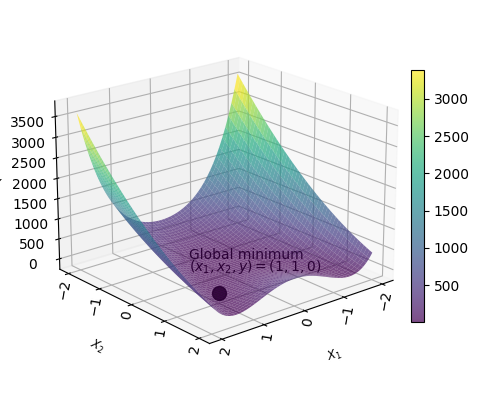

In [4]:
ofile= os.path.join(outputDir,'function_3D.png')
vsplt.plot_rosenbrock_3d(ofile)

#### 2. Generate input-output data

In [5]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input data (x) via uniform sampling throughout the feasible range.
x = np.zeros((nSample,nVar))
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding output data (y).
y = Rosenbrock_function(x)

# Save input-output data (x,y).
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))


Input-output data saved: ./outputs/samples_nVar2.txt


#### 3. Data conversion
##### 3.1 Normalize input-output data and get empirical CDF

In [7]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Normalize input-output data
x_norm = x.copy()
for ii in range(np.shape(x_norm)[1]):
    x_norm[:,ii] = vs.data_normalize(x[:,ii])
y_norm = vs.data_normalize(y)

# Calculate rank-based empirical marginal CDF
ux = x.copy()
for ii in range(np.shape(ux)[1]):
    ux[:,ii] = pseudo_obs(x[:,ii], ties='average')
uy = pseudo_obs(y, ties='average')

# Extract CDF for evaluated input-output data
u = np.concatenate((ux[:,xIndex].reshape((-1,1)),uy),axis=1)

##### 3.2 Plot input-output da, normalized, and CDF data
- When we compute the first-order sensitivity index of $x_1$ for the Rosenbrock function, two variables $(x_1,y)$ need included in the VISCOUS framework. 
- Through data preparation, three sets of data are obtained: input-output data $(x_1,y)$, normalized data $(x'_{1},y')$, and marginal CDF data $(u_{x_1},u_y)$.

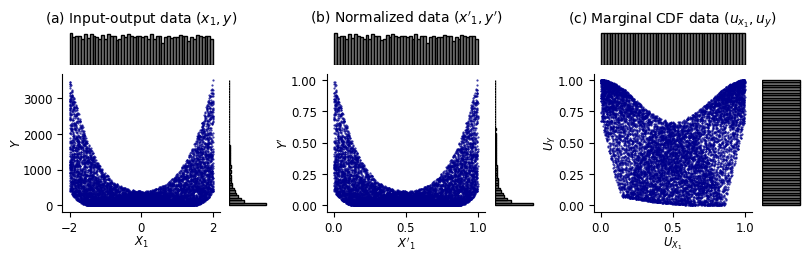

In [7]:
ofile = os.path.join(outputDir,'data.png')
vsplt.plot_data_conversion(x,y,x_norm,y_norm,ux,uy,xIndex,ofile)

#### 4. Calculate the first-order sensitivity index using two components
##### 4.1 Calculate sensitivity index
Calculate the Sobol' first-order sensitivity index using two Gaussian components.

In [5]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_2cpnt, gmcm_2cpnt = vs.viscous(x, y, xIndex, sensType, n_components=2)  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.450230


##### 4.2 Plot the inverse CDF data, their PDFs and clusters in GMM
- $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM.<br>
- Plot the histogram (panel a), GMM PDF (panel b), and GMM clustering (panel c) results for $(z_{x_1},z_y)$. <br>
- Note that due to the randomness nature of the GMCM inference process, the GMCM inference results may vary each time.

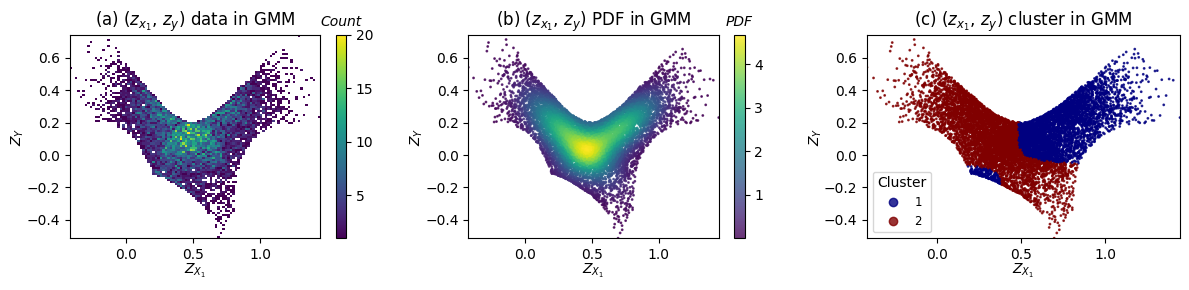

In [9]:
z_2cpnt = vs.gmm_marginal_ppf(u, gmcm_2cpnt.params)  # Approximates the inverse cdf of u given the GMCM parameters
ofile   = os.path.join(outputDir,'gmm_2cpnt.png')    # Output figure file
vsplt.plot_gmm_pdf_cluster(gmcm_2cpnt,z_2cpnt,ofile) # Plot

#### 5. Calculate the first-order sensitivity index using am optimal number of components
##### 5.1 Calculate sensitivity index
Calculate the Sobol' first-order sensitivity index using an optimal number of Gaussian components.

In [11]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_optm, gmcm_optm = vs.viscous(x, y, xIndex, sensType, n_components='optimal')  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
    n_component = 3
	initial 1: fitting completes with convergency.
    n_component = 4
	initial 1: fitting completes with convergency.
    n_component = 5
	initial 1: fitting completes with convergency.
    n_component = 6
	initial 1: fitting completes with convergency.
    n_component = 7
	initial 1: fitting completes with convergency.
    n_component = 8
	initial 1: fitting completes with convergency.
    n_component = 9
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  8
    Sensitivity index = 0.500710


##### 5.2 Plot the inverse CDF data, their PDFs and clusters in GMM

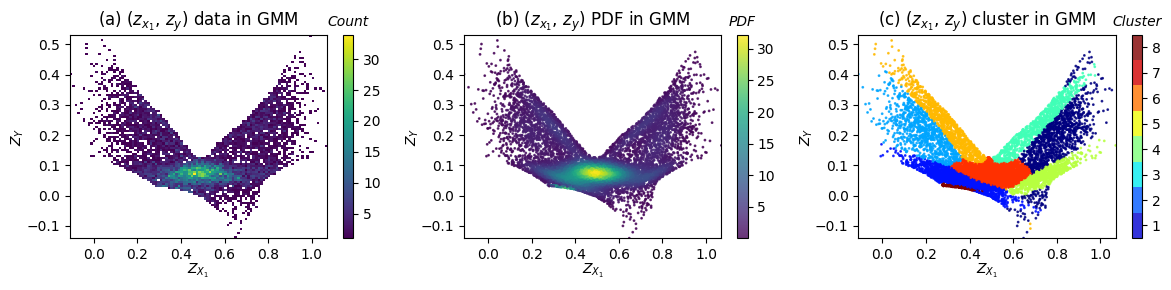

In [12]:
z_optm = vs.gmm_marginal_ppf(u, gmcm_optm.params)       # Approximates the inverse cdf of u given the GMCM parameters
ofile  = os.path.join(outputDir,'gmm_optimal_cpnt.png') # Output figure file
vsplt.plot_gmm_pdf_cluster(gmcm_optm,z_optm,ofile)      # Plot

#### 6. Optional plots for better understanding GMM
##### 6.1 Plot the GMM individual components
When using two Gaussian components, plot the individual GMM components in the format of contour. A weighted mixture of all components constitutes the GMM. This plot is to help visualize how multiple Gaussian components constitute the GMM.

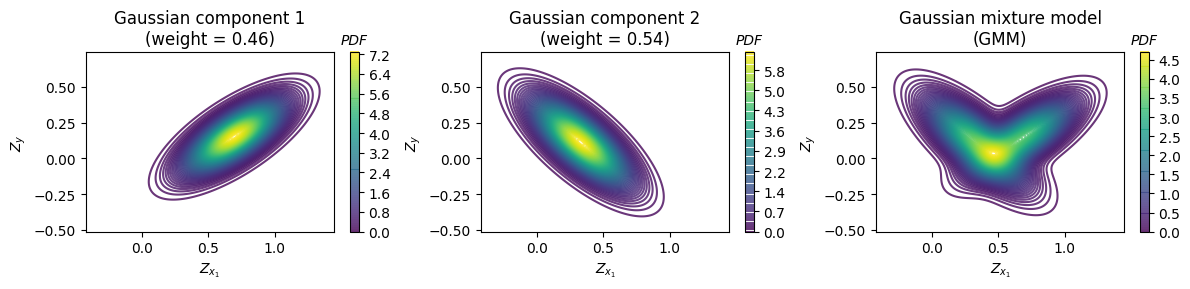

In [10]:
z_2cpnt = vs.gmm_marginal_ppf(u, gmcm_2cpnt.params)        # Approximates the inverse cdf of the input given the GMCM parameters
ofile   = os.path.join(outputDir,'gmm_2cpnt_contour.png')  # Output figure file
vsplt.plot_gmm_counter(gmcm_2cpnt, z_2cpnt, xIndex, ofile) # Plot

##### 6.2 Plot GMM marginal distributions
Plot the histogram of $z_{x_1}$ and $z_y$ data in the marginal distributions of GMM. For example, <br>
- The first subplot shows the two histograms of $z_{x_1}$ data in the two $Z_{X_1}$ marginal distributions of GMM. <br>
- The two $Z_{X_1}$ marginal distributions are from the two GMM components. <br>

Note the following code is valid for the first-order sensitivity. Please adjust for use of the total-order sensitivity.
##### 6.2.1 GMM with two Gaussian components

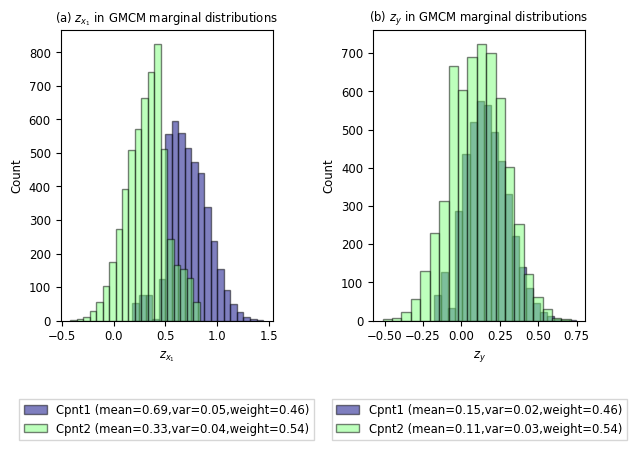

In [8]:
ofile = os.path.join(outputDir,'gmm_2cpnt_marginal_dists.png')   # Output figure file
vsplt.plot_gmm_marginal_dists(u, gmcm_2cpnt, xIndex, ofile)      # Plot

##### 6.2.2 GMM with an optimal number of Gaussian components

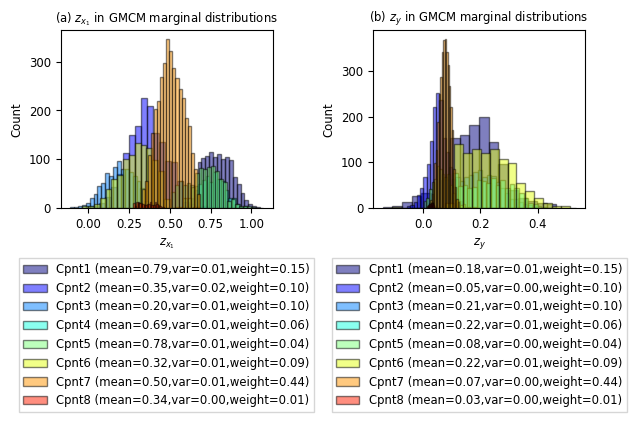

In [13]:
ofile = os.path.join(outputDir,'gmm_optm_cpnt_marginal_dists.png')  # Output figure file
vsplt.plot_gmm_marginal_dists(u, gmcm_optm, xIndex, ofile)          # Plot